# 2. K-Means Analysis

In [35]:
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.collections import PathCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Choice of attributes

In [2]:
df_01_scaled = pd.read_csv('data/HR_comma_sep_01_scaled.csv', index_col=0)
# choice of attributes: K means works better with quantitative features.
# Euclidean distance is not meaningful for categorical features
numerical_features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']
train_data = np.array(df_01_scaled[numerical_features])

## Kmeans

### choice of best value of k

In [3]:
# choice of best value of  K that minimizes the sum of squared error
sse_list = list([0] * 49)
silhouette_list = list([0] * 49)
max_k = 50

for k in range(2, max_k + 1):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse_list[k-2] = kmeans.inertia_
    silhouette_list[k-2] = silhouette_score(train_data, kmeans.labels_) 

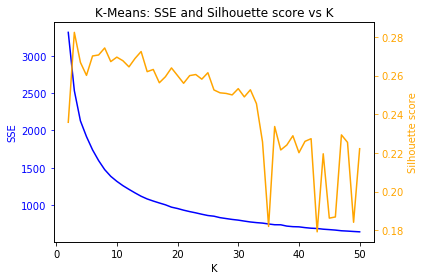

In [4]:
# plot SSE and silhouette on the same scale
# first axis
fig, ax1 = plt.subplots()
ax1.plot(range(2, max_k+1), sse_list, 'b')
ax1.set_xlabel('K')
ax1.set_ylabel('SSE', color='b')
ax1.tick_params('y', colors='b')
# second axis
ax2 = ax1.twinx()
ax2.plot(range(2, max_k+1), silhouette_list, 'orange')
ax2.set_ylabel('Silhouette score', color='orange')
ax2.tick_params('y', colors='orange')

plt.title('K-Means: SSE and Silhouette score vs K')
fig.tight_layout()
plt.savefig('images/sse_silhouette_vs_k.png')
plt.show()
# a way to chose the best k is to look at the 'elbow point' that is the point where the sse drops significantly.

In [11]:
print 'max silhouette:', np.max(silhouette_list), 'arg:', np.argmax(silhouette_list), 'k:', np.argmax(silhouette_list)+2
print 'min silhouette:', np.min(silhouette_list), 'arg:', np.argmin(silhouette_list), 'k:', np.argmin(silhouette_list)+2
print 'max sse:', np.max(sse_list), 'arg:', np.argmax(sse_list), 'k:', np.argmax(sse_list)+2
print 'min sse:', np.min(sse_list), 'arg:', np.argmin(sse_list), 'k:', np.argmin(sse_list)+2

diffs = [0] * len(sse_list)
max_sse = np.max(sse_list)
for i in range(1, len(sse_list)-2):
    diffs[i] = abs(sse_list[i] - sse_list[i-1])

print 'max sse diffs:', np.max(diffs), 'arg:', np.argmax(diffs), 'sse:', sse_list[np.argmax(diffs)], 'silhouette:', silhouette_list[np.argmax(diffs)]
print 'min sse diffs:', np.min(diffs), 'arg:', np.argmin(diffs), 'sse:', sse_list[np.argmin(diffs)], 'silhouette:', silhouette_list[np.argmin(diffs)]
top_diffs_args = (-np.array(diffs)).argsort()[:5]
top_silho_args = (-np.array(silhouette_list)).argsort()[:5]
print 'top 5 diffs args:', top_diffs_args, '--> k:', top_diffs_args + 2  # add +2 to get corresponding k
print 'top 5 silhouette args:', top_silho_args, '--> k:', top_silho_args + 2

max silhouette: 0.282406398599 arg: 1 k: 3
min silhouette: 0.179199727324 arg: 41 k: 43
max sse: 3315.02944927 arg: 0 k: 2
min sse: 641.160565646 arg: 48 k: 50
max sse diffs: 781.896351961 arg: 1 sse: 2533.13309731 silhouette: 0.282406398599
min sse diffs: 0.0 arg: 0 sse: 3315.02944927 silhouette: 0.235882726558
top 5 diffs args: [1 2 3 4 5] --> k: [3 4 5 6 7]
top 5 silhouette args: [ 1  6 12  5  4] --> k: [ 3  8 14  7  6]


In [14]:
# another approach: from the SSE graph select the point with minimum distance from the origin
scaler_x, scaler_y = MinMaxScaler(), MinMaxScaler()
xs = scaler_x.fit_transform([i for i in range(len(sse_list))])
ys = scaler_y.fit_transform(sse_list)

distances_from_origin = [np.linalg.norm([x,y]) for x,y in zip(xs,ys)]
argmin_distances = np.argmin(distances_from_origin)
k = argmin_distances + 2
print 'elbow point: (k= %d, sse = %f, silhouette = %f)' % (k, sse_list[k],  silhouette_list[k])

elbow point: (k= 12, sse = 1118.110615, silhouette = 0.272495)


/home/carlo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carlo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carlo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your 

In [16]:
chosen_k = k

In [17]:
# analysis of the k centroids for a chosen k
kmeans = KMeans(n_clusters=chosen_k)
kmeans.fit(train_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
# 2D PCA highlighting the clusters
pca = PCA(n_components=2)
X_scaled_2D = pca.fit_transform(train_data)

In [39]:
type(plt.scatter([1], [2], c='r'))
l = [PathCollection] * 10
print len(l), type(l[0])

10 <type 'type'>


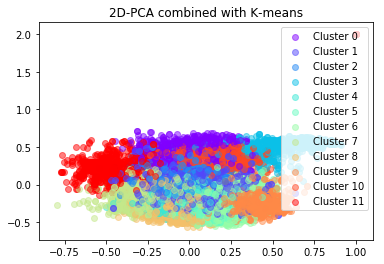

In [40]:
# plot PCA
# color_list = plt.cm.Set3(np.linspace(0, 1, 12)) (Set3, tab20)
colors = cm.rainbow(np.linspace(0, 1, chosen_k))
labels = [PathCollection] * len(colors)
for i in range(0, X_scaled_2D.shape[0]):
    x, y = X_scaled_2D[i, 0], X_scaled_2D[i, 1]
    label_i = kmeans.labels_[i]
    c = colors[label_i]
    labels[label_i] = plt.scatter(x, y, c=colors[label_i], alpha=0.5)
    
plt.legend([l for l in labels], ['Cluster %d' % i for i in range(0, len(labels))])    
plt.title('2D-PCA combined with K-means')
plt.savefig('images/pca_kmeans.png')
plt.show()

## Analysis of k centroids

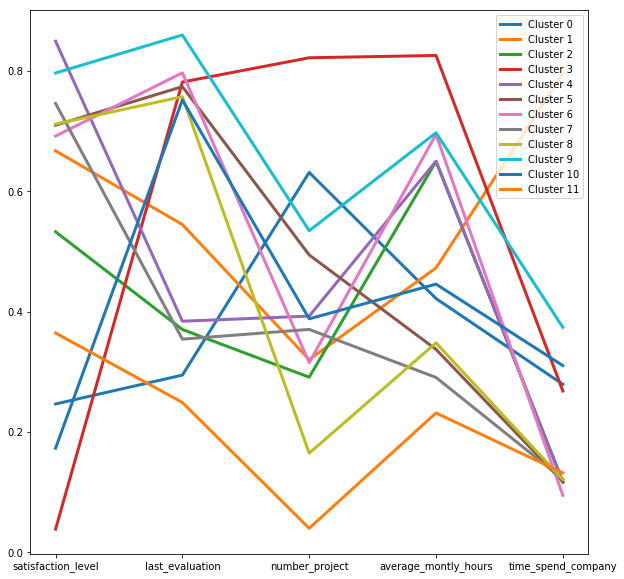

In [42]:
plt.figure(1, figsize=(10, 10))
for i in range(0, len(kmeans.cluster_centers_)):
    plt.plot(range(0, train_data.shape[1]), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(0, train_data.shape[1]), list(df_01_scaled.columns))
plt.legend()
plt.savefig('images/k-centroids_analysis.png')
plt.show()


### compare distributions of features within clusters (and the entire dataset)

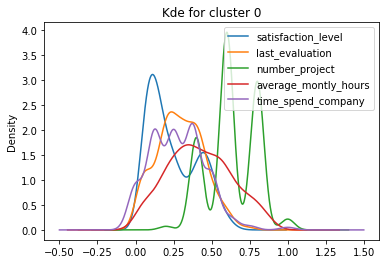

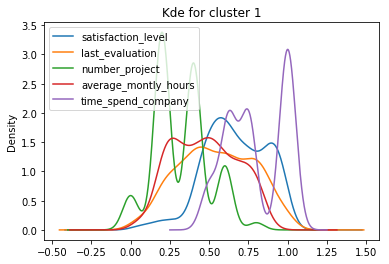

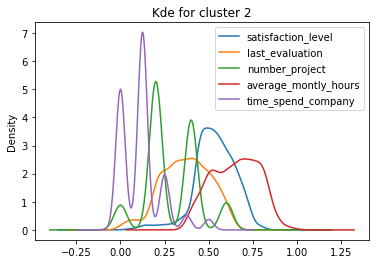

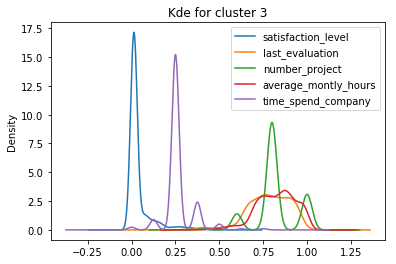

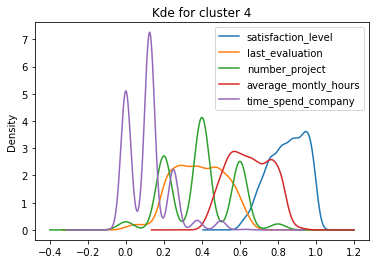

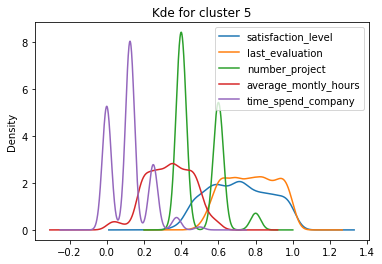

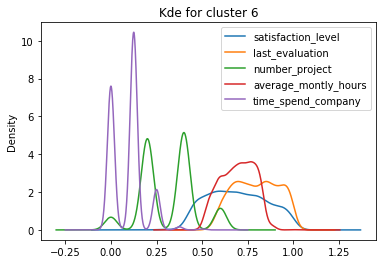

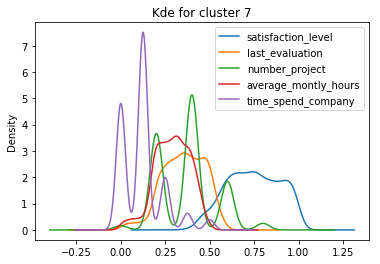

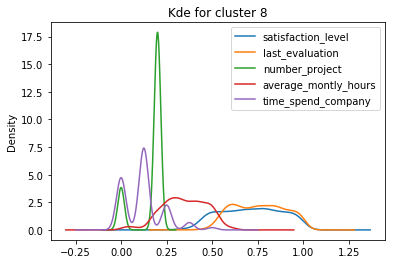

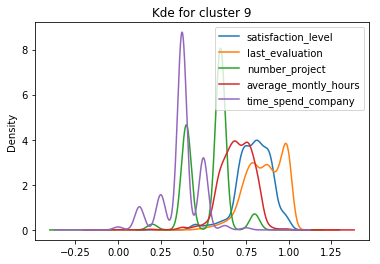

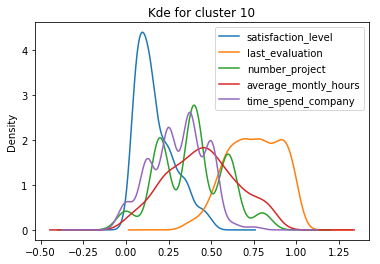

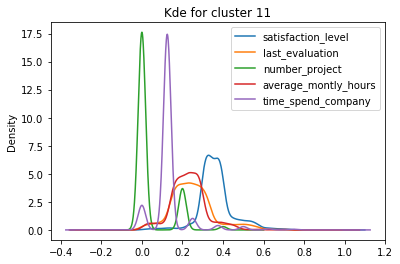

In [46]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'][:len(numerical_features)]
df_cluster = pd.DataFrame(train_data, columns=numerical_features)
df_cluster['cluster'] = kmeans.labels_
alpha = 1
for i in range(chosen_k):
    cluster_i = df_cluster[df_cluster['cluster'] == i][numerical_features]
    for col in cluster_i:
        cluster_i[col].plot(kind='kde')
    plt.title('Kde for cluster %d' % i)
    plt.legend()
    plt.savefig('images/kde_within_clusters_c' + str(i) + '.png')
    plt.show()
    
# TODO: evaluate numerically, too many clusters

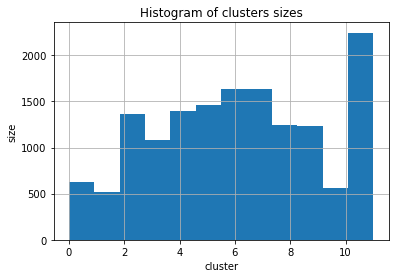

In [47]:
# cluster's size histogram
df_cluster['cluster'].hist(bins=chosen_k)
plt.xlabel('cluster')
plt.ylabel('size')
plt.title('Histogram of clusters sizes')
plt.savefig('images/kmeans_cluster_size_hist.png')
plt.show()